Schelling's Model

In [923]:
import random
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.cm as cm
import imageio
from IPython.display import HTML
import cmath
from scipy import signal

from pylab import rcParams
rcParams['figure.figsize'] = 14, 11
matplotlib.rc('font', **{'size': 20})
%matplotlib inline
from mpl_toolkits import mplot3d

In [911]:
class Life():
    def __init__(self,
                 agents_percent=0.5,
                 low_threshold=1,
                 high_threshold=8,
                 field_size=100,
                 dimensions=2,
                store_history=False,
                make_gif=True):
        '''
        Creates a class for the game of life.
        
        @param agents_percent (float): per cent of filled cells.
        @param low_threshold (int): agent wants to move if it has less tham low_threshold neighbors.
        @param high_threshold (int): agent wants to move if it has more tham low_threshold neighbors.
        @param field_size (int): size of the map dimention.
        @param dimensions (int): number od dimensions.
        @param store_history (bool): if True, collects maps at each iteartion in self._history.
        @param make_gif (bool): if True, creates a gif of the game.
    
        '''
        
        assert dimensions in [2, 3]
        assert agents_percent <= 1
        assert low_threshold >= 0
        assert high_threshold <= (3 ** dimensions) - 1
        
        self._dimensions = dimensions
        self._agents_percent = agents_percent
        self._field_size = field_size
        self._low_threshold = low_threshold
        self._high_threshold = high_threshold
        self._store_history = store_history
        self._make_gif = make_gif
        
        self._agents_count = []
        self._unstable_agents_count = []
        
        self._get_init_map()
        self._calculate_state()
        self._history = [self._map.copy()]
        
        if self._make_gif:
            self._gif_name = (
                'Life' + 
                '_l' + str(self._low_threshold) +
                '_s' + str(self._field_size) +
                '_' + str(self._dimensions) + 'd')
    
    def play(self, steps):
        ''' Iterates the game loop '''
        if self._make_gif:
            with imageio.get_writer('./data/' + self._gif_name + '.gif', mode='I') as writer:
                for i in range(steps):
                    self.step()
                    self.show(display=False, save=True)
                    writer.append_data(imageio.imread('./data/' + self._gif_name + '.jpg'))
        
            return './data/' + self._gif_name + '.gif'
        else:
            for i in range(steps):
                self.step()
            
#             self.show()
                    
    def step(self):
        ''' Makes one game step '''
        self._calculate_state()
        self._move()
        
        if self._store_history:
            self._history.append(self._map.copy())
    
    def show(self, display=True, save=False):
        ''' Plots current map state '''
        plt.ioff()
        
        if self._dimensions == 2:
            fig, axs = plt.subplots(1, 3, figsize=(15, 8))
            axs[0].set_title('City map')
            axs[0].matshow(self._map, cmap=cm.binary)
            axs[0].axis('off')

            axs[1].set_title('Moving map')
            axs[1].matshow(self._unstable, cmap=cm.binary)
            axs[1].axis('off')
            
            axs[2].set_title('Moving agents count')
            axs[2].plot(range(len(self._unstable_agents_count)), self._unstable_agents_count)
            
        if self._dimensions == 3:
            fig, axs = plt.subplots(1, 1, figsize=(10, 10))
            axs.set_title('City map')
            cz,cx,cy = self._map.nonzero()
            axs = fig.add_subplot(111, projection='3d')
            axs.scatter(cx, cy, -cz, zdir='z', c='green')
            axs.axis('off')

#             axs[1].set_title('Moving map')
#             mz,mx,my = self._unstable.nonzero()
#             axs[1] = fig.add_subplot(111, projection='3d')
#             axs[1].scatter(mx, my, -mz, zdir='z', c='green')
#             axs[1].axis('off')    
        
        if display:
            plt.show()
        if save:
            plt.savefig('./data/' + self._gif_name + '.jpg')
            plt.close(fig)
        
    def _get_init_map(self):
        ''' Randomly distributes agents '''
        self._map = (
            np.random.rand(*[self._field_size for i in range(self._dimensions)]) < self._agents_percent
        ).astype(int)
    
    def _count_neighbors(self):
        ''' Returns matrix with counts of each elements' neighbors '''
        a = self._map
        b = np.zeros(tuple([i + 2 for i in a.shape]))
        neighbors = []
        
        if self._dimensions == 2:
            neighbors = self._count_neighbors_2d(a, b)
        if self._dimensions == 3:
            neighbors = self._count_neighbors_3d(a, b)
        
        self._neighbors = neighbors
        
    def _count_neighbors_2d(self, a, b):
        b[1:-1, 1:-1] = a
        result = np.zeros(a.shape)

        for i in range(a.shape[0]):
            for j in range(a.shape[1]):
                result[i, j] = self._sum_matrix(b[i:i+3, j:j+3])
        return (result - a).astype(int)
    
    def _count_neighbors_3d(self, a, b):
        b[1:-1, 1:-1, 1:-1] = a
        result = np.zeros(a.shape)

        for i in range(a.shape[0]):
            for j in range(a.shape[1]):
                for k in range(a.shape[2]):
                    result[i, j, k] = self._sum_matrix(b[i:i+3, j:j+3, k:k+3])
        return (result - a).astype(int)
    
    def _get_unstable(self):
        ''' Returns arrays of unstable agents' coordinates '''
        self._unstable = (((self._low_threshold > self._neighbors) | 
                          (self._neighbors > self._high_threshold)) &
                         (self._map)).astype(int)
        
    def _calculate_state(self):
        self._count_neighbors()
        self._get_unstable()
        
        self._unstable_agents_count.append(self._sum_matrix(self._unstable))
        self._agents_count.append(self._sum_matrix(self._map))
        
    def _move(self):
        new_ext_map = np.ones(tuple([i + 2 for i in self._map.shape]))
        
        if self._dimensions == 2:
            new_ext_map[1:-1, 1:-1] = self._map.copy()
        if self._dimensions == 3:
            new_ext_map[1:-1, 1:-1, 1:-1] = self._map.copy()
        
        for i in list(zip(*self._unstable.nonzero())): # Looping through unstable cells
            cell_coords = list(np.array(i) + np.array([1] * self._dimensions)) # Extended matrix coords
            available = self._get_available_cells(new_ext_map, cell_coords)
            if len(available) == 0: # No empty cells
                continue
                
            target = np.array(random.choice(available))
            target += np.array(cell_coords) - np.array([1] * self._dimensions)
            
            if self._dimensions == 2:
                new_ext_map[target[0], target[1]] = 1
                new_ext_map[cell_coords[0], cell_coords[1]] = 0
            if self._dimensions == 3:
                new_ext_map[target[0], target[1], target[2]] = 1
                new_ext_map[cell_coords[0], cell_coords[1], cell_coords[2]] = 0
            
        if self._dimensions == 2:
            new_map = new_ext_map[1:-1, 1:-1]
        if self._dimensions == 3:
            new_map = new_ext_map[1:-1, 1:-1, 1:-1]
            
        self._map = new_map.astype(int)
    
    def _get_available_cells(self, matr, coords):
        assert len(coords) == self._dimensions
        
        if self._dimensions == 2:            
            return np.argwhere(matr[coords[0]-1:coords[0]+2, coords[1]-1:coords[1]+2] == 0)
        
        if self._dimensions == 3:
            return np.argwhere(matr[coords[0]-1:coords[0]+2, coords[1]-1:coords[1]+2, coords[2]-1:coords[1]+2] == 0)
    
    def _sum_matrix(self, matrix):
        return sum(np.ravel(matrix))
    

In [917]:
game = Life(agents_percent=0.5,
            low_threshold=4,
            high_threshold=7,
            field_size=100,
            dimensions=2,
           store_history=False,
           make_gif=True)

In [918]:
%%time
HTML('<img src="' + game.play(100) + '"/>')

CPU times: user 22.5 s, sys: 79.7 ms, total: 22.5 s
Wall time: 22.6 s


Different initial ratios

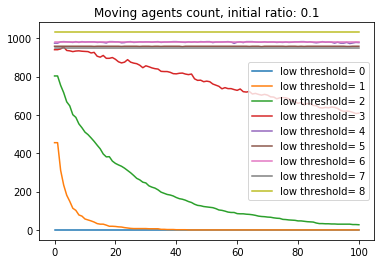

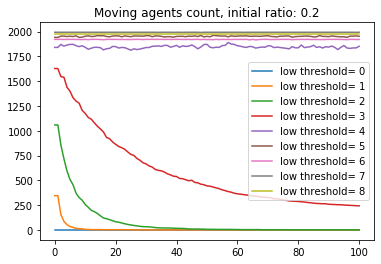

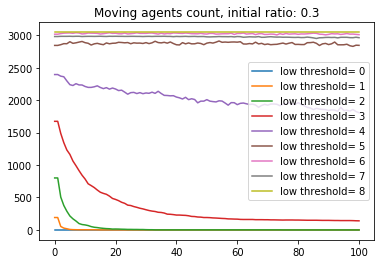

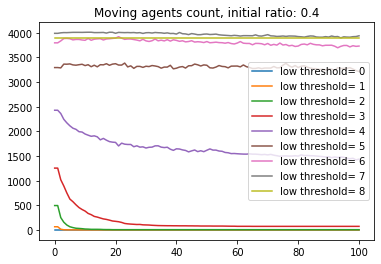

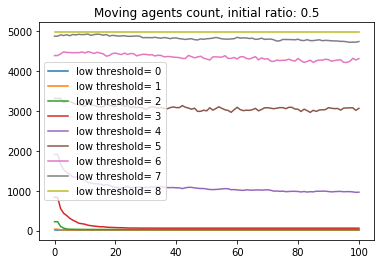

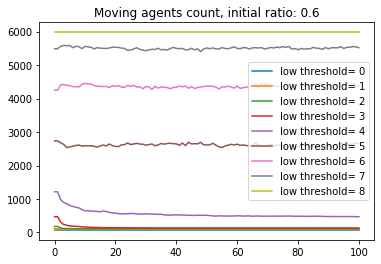

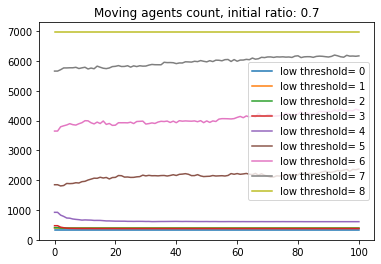

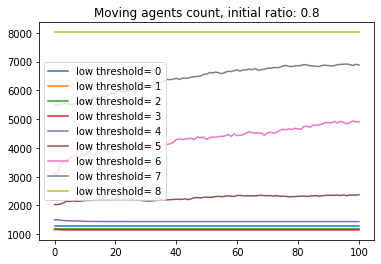

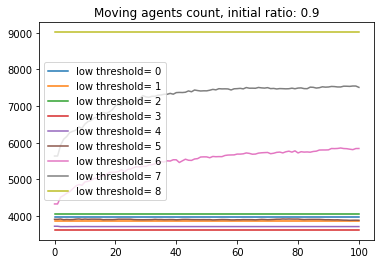

CPU times: user 13min 5s, sys: 1.32 s, total: 13min 6s
Wall time: 13min 5s


In [912]:
%%time
for j in [r / 10 for r in range(1, 10)]:
    for i in range(9):
        game = Life(agents_percent=j,
                low_threshold=i,
                high_threshold=7,
                field_size=100,
                dimensions=2,
               store_history=False,
               make_gif=False)

        game.play(100)
        plt.plot(game._unstable_agents_count, label='low threshold= ' + str(i))

    plt.title('Moving agents count, initial ratio: ' + str(j))
    plt.legend()
    plt.show()
    

Large field, lond duration

In [913]:
game = Life(agents_percent=0.5,
            low_threshold=4,
            high_threshold=7,
            field_size=250,
            dimensions=2,
           store_history=False,
           make_gif=True)

In [914]:
%%time
HTML('<img src="' + game.play(500) + '"/>')

CPU times: user 4min 42s, sys: 944 ms, total: 4min 43s
Wall time: 4min 42s


3D

In [889]:
game = Life(agents_percent=0.5,
            low_threshold=4,
            high_threshold=7,
            field_size=25,
            dimensions=3,
           store_history=False,
           make_gif=True)

In [892]:
%%time
HTML('<img src="' + game.play(100) + '"/>')

CPU times: user 2min 40s, sys: 1.94 s, total: 2min 42s
Wall time: 1min 9s


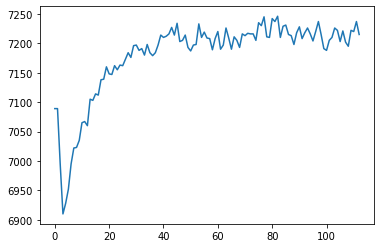

In [894]:
plt.plot(game._unstable_agents_count)

CPU times: user 13min 22s, sys: 10.1 s, total: 13min 32s
Wall time: 5min 46s


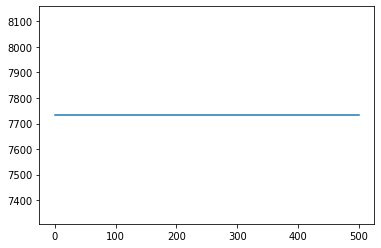

In [915]:
%%time
game = Life(agents_percent=0.5,
            low_threshold=10,
            high_threshold=7,
            field_size=25,
            dimensions=3,
           store_history=False,
           make_gif=True)

game.play(500)
plt.plot(game._unstable_agents_count)

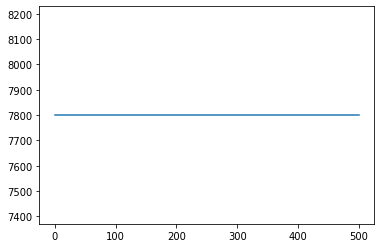

In [916]:
game = Life(agents_percent=0.5,
            low_threshold=20,
            high_threshold=7,
            field_size=25,
            dimensions=3,
           store_history=False,
           make_gif=True)

game.play(500)
plt.plot(game._unstable_agents_count)